## Thesis Project: Identify factors of the start-up ecosystem in Nigeria on Twitter 

### Basic preprocessing and data retrieval

In [20]:
import contractions
import emoji
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import json
import html
from wordcloud import WordCloud
from nltk.util import ngrams
from rapidfuzz import process, fuzz

# text preprocessing
! pip install -U pip setuptools wheel
! pip install -U spacy
! python -m spacy download en_core_web_sm
#Consider hashtags as a whole token
import spacy
from spacy.tokenizer import _get_regex_pattern
import preprocessor as tweet_preprocessor
from fuzzywuzzy import fuzz
from ttp import ttp
import string
import re
import  unicodedata
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize, sent_tokenize, FreqDist, pos_tag
from nltk.corpus import stopwords, wordnet
from collections import defaultdict
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import spacy
nlp = spacy.load('en_core_web_sm')
import itertools
from datetime import datetime

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 2.8 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.6/12.8 MB 2.8 MB/s eta 0:00:05
     ------ --------------------------------- 2.1/12.8 MB 2.9 MB/s eta 0:00:04
     -------- ------------------------------- 2.6/12.8 MB 2.7 MB/s eta 0:00:04
     ---------- ----------------------------- 3.4/12.8 MB 2.8 MB/s eta 0:00:04
     ------------ --------------------------- 3.9/12.8 MB 2.8 MB/s eta 0:00:04
     -------------- ------------------------- 4.7/12.8 MB 2.9 MB/s eta 0:00:03
     ---------------- ----------------------- 5.2/12.8 MB 2.8 MB/s eta 0:00:03
     ------------------ --------------------- 5.8/12.8 MB 2.8 MB/s eta 0:00:03
     ------------------- -------------------- 6.3/12.8 MB 2.8 MB/s eta 0:00:03
     --------------------- ------------------ 6.8/12.8 MB 2

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Thanos\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thanos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thanos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thanos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Thanos\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Why Twitter platform was chosen to be examined? 
- check public accessible data from the Statcounter Global Stat about social media usages trends overtime 
- (from this plot the Facebood platform is excluded because its usage rate outweighs the other platforms)

In [ ]:
social_media_usage = pd.read_csv('social_media_usage.csv')

In [22]:
#convert to datetime and keep the year 
social_media_usage['Date'] = pd.to_datetime(social_media_usage['Date'] , format='%Y-%m', errors='coerce').dt.year

In [36]:
yearly_mean = social_media_usage.groupby('Date').mean()

In [53]:
percent_mean = yearly_mean.apply(lambda row: row / row.sum(), axis=1)

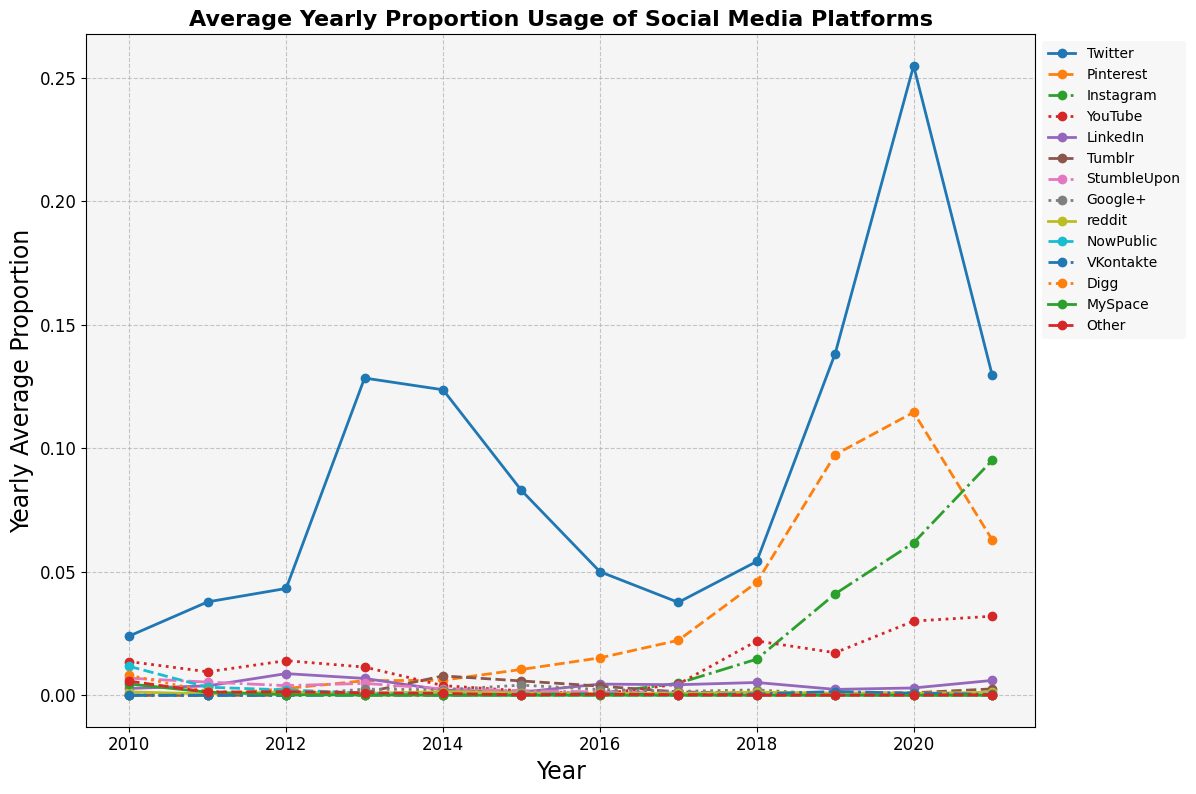

In [76]:
plt.figure(figsize=(12, 8))
plt.rcParams['axes.facecolor'] = 'whitesmoke'

# Iterate over each column except for 'Date' and plot the line
for column in percent_mean.columns[1:]:
    plt.plot(percent_mean.index, percent_mean[column], marker='o', label=column, linewidth=2)

# Customize line colors and styles
plt.gca().set_prop_cycle(None)  # Reset the color cycle
line_styles = ['-', '--', '-.', ':']
for i, line in enumerate(plt.gca().get_lines()):
    line.set_linestyle(line_styles[i % len(line_styles)])

# Add labels and title
plt.xlabel('Year', fontsize=17)
plt.ylabel('Yearly Average Proportion', fontsize=17)
plt.title('Average Yearly Proportion Usage of Social Media Platforms', fontsize=16, fontweight='bold')

# Customize legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, edgecolor='none')

# Customize grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust spacing and font sizes
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot as a PNG image
plt.savefig('line_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## 1. Basic preprocessing and features selection

In [61]:
class DataProcessor:
    def __init__(self, data=None):
        """
        Initialize the DataProcessor with data.
        
        Parameters:
        data (DataFrame or None): An optional pandas DataFrame to initialize with. If None, the data will be loaded later.
        """
        self.data = data
    
    def load_dataset(self, file_name):
        """
        Load a CSV file from the 'datasets' directory into a pandas DataFrame.
        
        Parameters:
        file_name (str): The name of the CSV file to be loaded.
        
        Returns:
        None: The data is loaded into the instance attribute 'data'.
        """
        # Get the current working directory
        current_dir = os.getcwd()
        
        # Define the 'datasets' folder relative to the current working directory
        base_dir = os.path.join(current_dir, '..', 'datasets')
        
        # Construct the full path to the CSV file
        file_path = os.path.join(base_dir, file_name)
        
        # Load the dataset
        self.data = pd.read_csv(file_path, low_memory=False, usecols=['id', 'tweet', 'created_at'])

    def clean_data(self):
        """
        Clean the data. This method should be implemented with specific cleaning operations.
        
        Returns:
        None
        """
        if self.data is None:
            print("No data to clean. Please load the dataset first.")
            return
        
        # Specify the word to search for
        keywords = ["startups", "#startups", "startup", "startups"]
        
        # Filter the DataFrame based on the specific column containing the word
        self.data = self.data[self.data['tweet'].str.contains('|'.join(keywords), case=False, na=True)]
        
        # Convert 'created_at' column to datetime format
        self.data['created_at'] = pd.to_datetime(self.data['created_at'], format='%Y-%m-%d %H:%M:%S+00:00', errors='coerce')
        
        # Keep only columns that we will utilize for text mining
        self.data = self.data[["id", "tweet", 'created_at']].copy()
        
        # Check if there are any retweets and duplicates in the filtered data
        num_retweets = self.data["tweet"].str.contains('RT').sum()
        if num_retweets > 0:
            # Drop retweets
            self.data = self.data[~self.data.tweet.str.contains('RT')]
        
        # Remove duplicates
        self.data.drop_duplicates(keep='first', inplace=True)

In [89]:
# Create an instance of DataProcessor
processor = DataProcessor()

# Load the dataset
processor.load_dataset("nigeria_tech.csv")

# Clean the data
processor.clean_data()

# Access the cleaned data
cleaned_tweets = processor.data


In [90]:
cleaned_tweets

,id,tweet,created_at
7,8273821554,"Lagos, Nigeria has been added on @StartupDiges...",2010-01-27 10:05:23
208,14279110335,Why a Sudden Surge in Tech M&A? Startups Pay A...,2010-05-19 06:34:58
210,14221652333,Have you read my Memeburn review of Nigeria's ...,2010-05-18 11:27:18
211,14221497686,Have you read my Memeburn review of Nigeria's ...,2010-05-18 11:23:30
220,13382724346,Great overview of the startup tech scene in Ni...,2010-05-04 20:28:26
...,...,...,...
459711,1.46612E+18,***Countdown! Nigeria Tech Summit is pleased t...,2021-12-01 19:05:01
459738,1.46608E+18,****Countdown! Nigeria Tech Summit is pleased ...,2021-12-01 16:05:03
459813,1.46599E+18,📣 CALLING FEMALE LEADERS! We're inviting inte...,2021-12-01 10:14:09
459829,1.46597E+18,Total funding raised by African Startups in 20...,2021-12-01 08:52:28


### 1.1 Tweets preprocessing:
- retrieve tweets that refer to start-ups,
- data cleaning: keep only relevant columns, remove duplicates and fuzzy duplicated tweets(very similar tweets that unimportant details) resulting in 12250 tweets. 

In [4]:
# Specify the word to search for
keywords = ["startups", "#startups", "startup", "startups"]
# Filter the DataFrame based on the specific column containing the word
start_ups = tech[tech['tweet'].str.contains('|'.join(keywords), case=False, na=True)]

In [5]:
# Convert 'created_at' column to datetime format
start_ups['created_at'] = pd.to_datetime(start_ups['created_at'], format='%Y-%m-%d %H:%M:%S+00:00', errors='coerce')

# Print the minimum and maximum values of 'created_at' column
print(start_ups['created_at'].min(), start_ups['created_at'].max())

2010-01-27 10:05:23 2021-12-30 19:13:33


C:\Users\Thanos\AppData\Local\Temp\ipykernel_21548\2330660816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_ups['created_at'] = pd.to_datetime(start_ups['created_at'], format='%Y-%m-%d %H:%M:%S+00:00', errors='coerce')


In [6]:
# keep only columns that we will utilize for text mining
start_ups = start_ups[["id", "tweet",'created_at']].copy()

In [26]:
# there are 291288 retweets
start_ups["tweet"].str.contains('RT').sum()

0

In [7]:
print(start_ups['tweet'].shape)
# there are 291288 retweets
start_ups["tweet"].str.contains('RT').sum()

(36166,)


18048

In [8]:
# drop the retweets
start_ups = start_ups[~start_ups.tweet.str.contains('RT')]

In [9]:
print(start_ups.isnull().sum())

id            0
tweet         0
created_at    0
dtype: int64


In [10]:
#check if there duplicates
np.sum(start_ups.duplicated())
# remove duplicates 
start_ups.drop_duplicates(keep= 'first', inplace= True)

581

In [11]:
# remove duplicates 
start_ups.drop_duplicates(keep= 'first', inplace= True)

In [13]:
len(start_ups)

17537

In [14]:
# 12250 tweets after fuzzy matching de-duplication
len(df_unique)

12250

### 1.2 Main preprocessing step:
- Create different cleaning and features selection functions for topic modeling and sentiment analysis respectively

#### Functions for topic modelling


In [108]:
#Function for topic modelling
def preprocess_topic(to_clean):
    
    # Convert list to Pandas Series
    to_clean = pd.Series(to_clean)  

    to_clean = to_clean.astype(str)
    
    # lowercase
    to_clean = to_clean.str.lower() 
    
    #remove whitespaces
    to_clean = to_clean.str.strip()
    
    # remove URLs
    to_clean = to_clean.str.replace(r"http\S+", '', regex=True) 
    
    #handling with contraction issues
    to_clean = to_clean.str.replace("’","'")
    to_clean = to_clean.str.replace("nigeria's","nigeria")
    to_clean = to_clean.str.replace("google's","google")
    to_clean = to_clean.apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
    
    # remove digits
    to_clean = to_clean.str.translate(str.maketrans(' ', ' ', string.digits))
    
    #remove any non alphabetic characters except of hashtags
    to_clean = [re.sub(r"(?<![#])([^a-zA-Z#\s]+)", " ", x) for x in to_clean]
    
    # remove all types of whitespaces                                                                        
    to_clean = [re.sub(r"\s+", " ", x.strip()) for x in to_clean]     
    
    return to_clean


#feature selection function for topic modelling
#function taken from the Critical Data Mining course
def topic_model_features(x, tags=['PROPN', 'NOUN']):
    include_features = tags  # see the table below for an explanation of tags, try different combinations
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])
    return text

#remove stopwords and frequently occured words
stop_words = stopwords.words('english')
new_stopwords = ['amp','g','gt','b','n','#','k',"via","ng","w",'tech','nigeria', '#tech','startups',
                 '#startup', '#startups', '#nigeria','#africa', 'startup', 'africa','new',
                 'nigerian', '#technology']  #some noisy characters that need to be removed
stop_words.extend(new_stopwords)

In [109]:
# Apply preprocessing function to 'tweet' column
cleaned_tweets['text_topic'] = preprocess_topic(cleaned_tweets['tweet'])

cleaned_tweets['text_topic'] = cleaned_tweets['text_topic'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


#### Functions for sentiment analysis


In [106]:
def preprocess_sentiment(to_clean):
    
    # Convert list or Series to Pandas Series
    to_clean = pd.Series(to_clean)
    
    # Convert to string type
    to_clean = to_clean.astype(str)
    
    # Remove whitespaces
    to_clean = to_clean.str.strip()
    
    # Remove hyperlinks
    to_clean = to_clean.str.replace(r"http\S+|www\S+", '', regex=True)
    
    # Remove digits
    to_clean = to_clean.str.translate(str.maketrans('', '', string.digits))
    
    # Remove mentions and hashtags using apply() for consistency
    to_clean = to_clean.apply(lambda x: re.sub(r"(?:#|@)\w+", "", x))
    
    # Remove excessive whitespaces using apply()
    to_clean = to_clean.apply(lambda x: re.sub(r"\s+", " ", x.strip()))
    
    # Remove HTML tags
    to_clean = to_clean.apply(lambda x: re.sub('<.*?>+', '', x))
    
    # Remove HTML entities using unescape
    to_clean = to_clean.apply(html.unescape)
    
    return to_clean

In [107]:
# Apply preprocessing function to 'tweet' column
cleaned_tweets['text_sentiment'] = preprocess_sentiment(cleaned_tweets['tweet'])


cleaned_tweets['text_sentiment'] = cleaned_tweets['text_sentiment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


### 1.3 Tokenization, feature selection and lemmatization

In [97]:
nlp = spacy.load('en_core_web_sm')

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match


<>:9: SyntaxWarning: invalid escape sequence '\w'
<>:9: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Thanos\AppData\Local\Temp\ipykernel_21548\1803936960.py:9: SyntaxWarning: invalid escape sequence '\w'
  re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"


In [113]:
#tokenize the clean text by using spacy library
cleaned_tweets['token_topic'] = cleaned_tweets['text_topic'].apply(lambda x:nlp(x))
cleaned_tweets['token_sentiment'] = cleaned_tweets['text_sentiment'].apply(lambda x:nlp(x))

In [107]:
#Include different feature for sentiment analysis and topic modelling respectivelly
cleaned_tweets['text_topic'] = cleaned_tweets['token_topic'].apply(lambda x: topic_model_features(x)) 

In [109]:
cleaned_tweets['topic_lemma'] = [lemmatizer.lemmatize(w) for w in cleaned_tweets['text_topic'].astype(str)]  

In [110]:
#remove again stopwords 
new_stopwords = ['amp','g','gt','b','n','#','k',"via","ng","w",'tech','nigeria', '#tech','startups',
                 '#startup', '#startups', '#nigeria','#africa', 'startup', 'africa','new',
                 'nigerian', '#technology','tech','startup','nigeria','nigerianstartup']
stop_words.extend(new_stopwords)
cleaned_tweets["topic_lemma"] = cleaned_tweets['topic_lemma'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


### 1.5 Hashtag extraction and wordcloud visualization

In [111]:
#extract the hashtags to a new column
def extract_hashtags(text):
    hashtags = re.findall(r"#(\w+)", text)
    return hashtags if hashtags else np.nan

# Apply the function to the "lemma" column and store the results in a new column "hashtags"
cleaned_tweets["hashtags"] = cleaned_tweets["topic_lemma"].apply(extract_hashtags)

In [112]:
np.sum(cleaned_tweets.isnull())

id                    0
tweet                 0
created_at            0
text_topic            0
text_sentiment        0
token_topic           0
token_sentiment       0
topic_lemma           0
hashtags           7812
dtype: int64

In [113]:
# Set a random seed for consistent results
random.seed(42)

hashtags = cleaned_tweets['hashtags'].dropna() 
hashtags = hashtags.apply(lambda x: [tag for tag in x if tag not in ["startups",'tech','startup','nigeria''nigerianstartup',
                                                                     'africanstartup','g','nigerian',"k", 'p']])

all_hashtags = [tag for sublist in hashtags for tag in sublist]

# Count the frequencies of each hashtag
hashtags_freq = Counter(all_hashtags)

# Print the hashtag frequencies
for tag, freq in hashtags_freq.most_common(50):
    print(f"{tag}: {freq}")

entrepreneur: 490
business: 419
lagos: 281
innovation: 270
news: 223
technews: 219
kenya: 213
ghana: 166
fintech: 158
southafrica: 147
internet: 146
ai: 133
entrepreneurship: 132
businessplans: 127
didyouknow: 120
teckexperts: 116
access: 112
grow: 111
entrepreneurs: 109
online: 103
blockchain: 96
apple: 91
apps: 90
fact: 89
socialmedia: 88
africabiz: 86
vc: 76
designtwitter: 74
endsars: 72
twitter: 68
investment: 67
analytics: 65
education: 62
money: 58
software: 56
developers: 55
mobile: 49
health: 48
growth: 48
insta: 46
covid: 46
abuja: 45
investor: 45
crypto: 43
uganda: 42
bizhour: 41
rwanda: 40
egypt: 40
portharcourt: 40
marketing: 39


#### Visualize hashtags wordcloud

Word cloud saved as: C:/Users/Thanos/PycharmProjects/Thesis_Project/wordcloud_hashtag.png


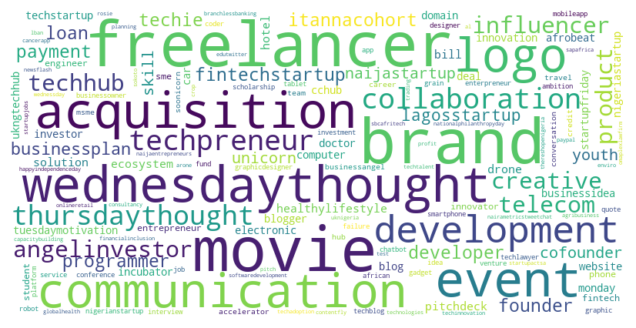

In [114]:
random.seed(42)
# Create an empty set to store unique hashtags
unique_hashtags = set()

# Iterate over each row in the 'hashtags' column
for row in hashtags:
    unique_hashtags.update(row)
    
# Join the unique hashtags into a single string
all_hashtags = ' '.join(unique_hashtags)


# Create a word cloud with customizations
wordcloud = WordCloud(width=800, height=400, background_color='white', max_font_size=80, 
                      contour_width=2, random_state=42,max_words=150).generate(all_hashtags)

## Display the word cloud
plt.figure(figsize=(8, 4))  # Adjust the dimensions as needed
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Save the word cloud as an image
output_path = 'C:/Users/Thanos/PycharmProjects/Thesis_Project/wordcloud_hashtag.png' 
plt.savefig(output_path, bbox_inches='tight', pad_inches=0.5)

# Show the path of the saved image
print(f"Word cloud saved as: {output_path}")

# Show the word cloud
plt.show()

### 1.6 Unigrams and bigrams

#### Remove hashtags from the tokens, topic_lemma and sent_lemma columns:
- Hashtags have been extracted to a new column.
- Maintaining them would add noise to the text

In [77]:
#remove hashtags from topic_lemma column because they add extra noise, 
#and we have already extract the hashtags previously
def remove_hashtags(text):
    cleaned_text = re.sub(r'#\w+\s*', '', text)
    return cleaned_text.strip()

df_unique['topic_lemma'] = df_unique['topic_lemma'].apply(remove_hashtags)
df_unique['token_topic'] = df_unique['token_topic'].apply(lambda x: [token.text for token in x if not token.text.startswith('#')])


In [78]:
df_unique['unigrams'] = df_unique['topic_lemma'].apply(lambda x: x.split())
# Access the unigrams, flatten them, and count occurrences 
flat_unigrams = [item for sublist in df_unique['unigrams'] for item in sublist]
unigram_counts = Counter(flat_unigrams)
unigram_counts.pop('', None)
unigram_counts.pop('e', None)
for unigram, count in unigram_counts.most_common(10):
    print(f'{unigram}: {count}')

post: 1674
lagos: 627
kenya: 515
hub: 494
ecosystem: 480
business: 407
funding: 367
news: 344
capital: 328
investment: 296


In [79]:
# Create bigrams from tokens
cleaned_tweets["bigrams"] = cleaned_tweets['topic_lemma'].apply(lambda x: list(ngrams(x.split(), 2)))

In [81]:
cleaned_tweets.to_csv('start.csv', index= False)